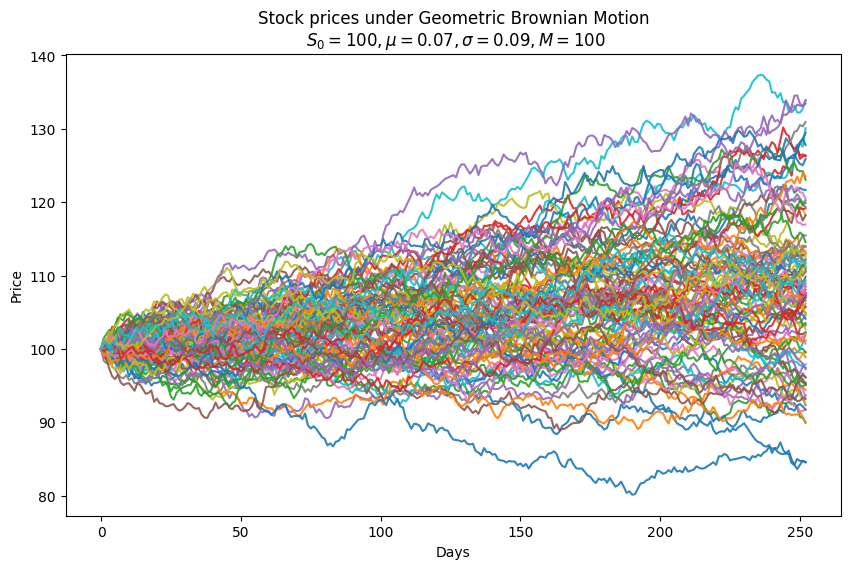

15.146432462374419


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [4]:
#Dependencies: backtesting yfinance pandas_market_calendars
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels
from statsmodels.tsa.stattools import coint

import yfinance as yf

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels
from statsmodels.tsa.stattools import coint

import yfinance as yf
mu = 0.07  # Drift coefficient
T = 1  # Time in years
n = 252 * T  # Number of steps (252 trading days per year)
M = 100  # Number of simulations
S0 = 100  # Initial stock price
sigma = nu_0  = 0.09  # Volatility
dt = T / n  # Step/period length

# Simulation using numpy arrays
St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(M, n)).T
)

# Include array of 1's for the initial price
St = np.vstack([np.ones(M), St])

# Multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0)
St = S0 * St.cumprod(axis=0)

# Convert to pandas DataFrame
data = pd.DataFrame(St, columns=[f'Stock price sim {i+1}' for i in range(M)])

# Plotting all simulation paths
plt.figure(figsize=(10, 6))

# Plot individual simulation stock prices
for i in range(M):
    plt.plot(data.index, data[f'Stock price sim {i+1}'], label=f'Simulation {i+1}', alpha=0.9)

plt.xlabel('Days')
plt.ylabel('Price')
plt.title(f"Stock prices under Geometric Brownian Motion\n $S_0 = {S0}, \\mu = {mu}, \\sigma = {sigma}, M = {M}$")
plt.show()

payoffs = data.copy ()

def option_value (strike_price, data):

    from sklearn.linear_model import LinearRegression
    payoffs = data.copy ()
    payoffs.loc[len(payoffs)] = [0] * payoffs.shape[1]

    for i in range (len (payoffs.index) - 2, -1, -1):

        last = payoffs.iloc [i]
        reg = LinearRegression().fit(payoffs.iloc[i].values.reshape(-1, 1),
                             payoffs.iloc[i+1].values.reshape(-1, 1))

        for col in payoffs.columns:
            immediate = max(last[col] - strike_price, 0)
            cont_val = reg.predict(np.array([[last[col]]]))[0, 0]
            payoffs.at[payoffs.index[i], col] = max(immediate, cont_val)

    return payoffs.iloc [0][0]

print (option_value (100, data))


def option_val(strike, rate, data):
    payoffs = (data - strike).clip(lower = 0) ## compute immediate exercise (max(S_t - K, 0))
    #print(f'payoffs: {payoffs}\n')
    disc_fact = np.exp(-rate)

    cashflowmat = np.zeros(data.shape)
    cashflowmat[-1, :] = payoffs.iloc[-1, :].values ## last cashflows are the payoffs

    for t in range(payoffs.shape[0] - 2, 0, -1): ## skip last (don't regress there)
        #payoffs.iloc[t, :] = (payoffs.iloc[t, :] - strike).clip(lower = 0) ## max(S_t - K, 0)

        ## regression step
        curr_row = payoffs.iloc[t]
        itm = (curr_row > 0).to_numpy().nonzero()[0] ## get indices where option is in the money
        #print(f'ITM: {itm}\n')
        if len(itm) < 2:  # Need at least 2 points to fit a quadratic polynomial
            continue  # Skip regression step and move to the next time step
        disc_payoff = cashflowmat[t + 1, itm] * disc_fact ## discounted cashflows received at next step if not exercised
        #print(f'disc_payoff: {disc_payoff}\n')
        price_itm = data.iloc[t, itm] ## price of the underlying where
        #print(f'price_itm: {price_itm}\n')

        ## disc_payoff = intercept + price_itm * x + price_itm * x**2
        regr = np.polyfit(x = price_itm, y = disc_payoff, deg = 2) ## returns coefficients with highest order first

        ## predicted continuation value
        regr_poly = np.poly1d(regr)
        cont_val = regr_poly(price_itm)
        #print(curr_row)
        #print(cont_val)

        cont_val_1 = np.zeros(data.shape[1])
        cont_val_1[itm] = cont_val
        #print(f'\ncont_val_1: {cont_val_1}\n')

        ex_idx = np.where(curr_row >= cont_val_1)[0] ## indices where exercise is better than or equal to continuation
        #print(f'\nex_idx: {ex_idx}\n')
        cont_idx = np.where(curr_row < cont_val_1)[0]
        #print(f'\ncont_idx: {cont_idx}\n')

        cashflowmat[t, ex_idx] = curr_row.values[ex_idx] ## add cash-flows/payoffs where exercise better to cash-flow matrix
        cashflowmat[t + 1, ex_idx] = 0 ## if exercising at t, have cashflow of 0 at t + 1
        ## for the cont_idx, don't do anything


        #print(f'\ncashflowmat: {cashflowmat}\n')

    ## to value option, discount each cash flow back to time zero and average over all paths
    ## there should only be one value per column in the cashflow matrix (for each state either hold (= 0) or exercise (!= 0, except for last state))

    no_sim = data.shape[1] ## number of simulations

    val_sim = np.zeros(no_sim) ## discounted cashflow for each simulation

    for col in range(cashflowmat.shape[1]): ## loop over columns of cashflow matrix
        cashflow_idx = cashflowmat[:, col].nonzero()[0] ## array of indices of all non-zero values (should have length one or be empty (if option is never exercised))
        if len(cashflow_idx) == 0:
            ## option never exercised
            val_sim[col] = 0 ## value of zero
        else:
            #print(f'\ncashflowmat[cashflow_idx, col]: {cashflowmat[cashflow_idx, col]}\nlength: {len(cashflowmat[cashflow_idx, col])}')
            #print(f'\nnp.exp(-rate * cashflow_idx): {np.exp(-rate * cashflow_idx)}\nlength: {len(np.exp(-rate * cashflow_idx))}')
            val_sim[col] = np.sum(cashflowmat[cashflow_idx, col] * np.exp(-rate * cashflow_idx)) ## discounted value = value * exp(- rate * time)

    avg_val = 1/no_sim * np.sum(val_sim)

    #print(cashflowmat) ## doesn't work properly, but almost; there should only be one value per column

    return avg_val


option_val(100, 0.03, data)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
from sklearn.linear_model import LinearRegression

# -------------------------------
# Step 1: Choose a longer-term option
# -------------------------------
ticker = yf.Ticker("AAPL")
all_exps = ticker.options  # list of expiration strings

# Use today's date (normalized to remove the time component)
today = pd.Timestamp.today().normalize()

# Filter for expiration dates at least 90 days from today
exp_dates = [pd.to_datetime(exp) for exp in all_exps]
valid_exps = [exp for exp in exp_dates if exp >= today + pd.Timedelta(days=90)]
if not valid_exps:
    chosen_exp = pd.to_datetime(all_exps[-1])  # fallback to the last available expiration
else:
    chosen_exp = min(valid_exps)
expiration_str = chosen_exp.strftime('%Y-%m-%d')

print("Chosen Expiration:", expiration_str)

# -------------------------------
# Step 2: Get trading days between now and expiry using NYSE calendar
# -------------------------------
nyse = mcal.get_calendar('NYSE')
# Use today's date and the chosen expiration date as strings
schedule = nyse.schedule(start_date=today.strftime('%Y-%m-%d'), end_date=expiration_str)
trading_days = mcal.date_range(schedule, frequency='1D')
n = len(trading_days)  # number of trading days
T = n / 252  # time in years (assuming 252 trading days per year)

print("Trading Days to Expiration:", n)

# -------------------------------
# Step 3: Select an at-the-money strike from the option chain and get the actual option price
# -------------------------------
option_chain = ticker.option_chain(expiration_str)
calls = option_chain.calls
# Get current stock price (using the latest close price)
current_price = ticker.history(period="1d")['Close'].iloc[-1]

# Choose the strike closest to the current stock price (i.e. near-the-money)
calls['diff'] = abs(calls['strike'] - current_price)
chosen_strike = calls.loc[calls['diff'].idxmin()]['strike']
# Get the market observed lastPrice for that strike
actual_option_price = calls.loc[calls['strike'] == chosen_strike]['lastPrice'].values[0]

print("Current Price:", current_price)
print("Chosen Strike:", chosen_strike)
print("Actual Option Price (Call):", actual_option_price)

# -------------------------------
# Step 4: Simulate stock price paths using Geometric Brownian Motion
# -------------------------------
# Use the current price as the initial stock price.
S0 = current_price
mu = 0.07     # drift coefficient
sigma = 0.09  # volatility
M = 100       # number of simulation paths
dt = T / n    # time step

# Generate stock returns and simulate paths:
# Note: The simulation will have 'n' steps; we add an initial row for time 0.
St = np.exp((mu - sigma**2/2)*dt + sigma*np.random.normal(0, np.sqrt(dt), size=(n, M)))
St = np.vstack([np.ones(M), St])
St = S0 * St.cumprod(axis=0)

# Create a DataFrame with index = 0,...,n (n+1 rows)
sim_data = pd.DataFrame(St, index=range(n+1), columns=[f'Sim {i+1}' for i in range(M)])

# -------------------------------
# Step 6: Compute predicted option prices using both models for the chosen strike
# -------------------------------
r = 0.03  # discount rate for the option_val model
predicted_price_model1 = option_value(chosen_strike, sim_data)
predicted_price_model2 = option_val(chosen_strike, r, sim_data)

print("\nPredicted Option Price (Model 1 - option_value):", predicted_price_model1)
print("Predicted Option Price (Model 2 - option_val):", predicted_price_model2)
print("Actual Option Price:", actual_option_price)

# -------------------------------
# Step 7: Plot the comparison of option prices for the chosen strike (Bar Chart)
# -------------------------------
labels = ['Actual Price', 'Model 1', 'Model 2']
prices = [actual_option_price, predicted_price_model1, predicted_price_model2]

plt.figure(figsize=(8, 6))
plt.bar(labels, prices, color=['blue', 'orange', 'green'])
plt.ylabel("Option Price")
plt.title(f"Option Price Comparison for Expiry {expiration_str}\nStrike {chosen_strike}")
plt.show()

# -------------------------------
# Step 8: Compare Option Prices vs. Strike Price with a Line Graph
# -------------------------------
# Extract the list of unique strikes from the calls option chain
unique_strikes = sorted(calls['strike'].unique())

# Compute predicted prices for each strike using the two models on the existing simulation data
model1_prices = [option_value(strike, sim_data) for strike in unique_strikes]
model2_prices = [option_val(strike, r, sim_data) for strike in unique_strikes]

# Extract the actual market call prices for each strike from the option chain
actual_prices = [calls.loc[calls['strike'] == strike, 'lastPrice'].values[0] for strike in unique_strikes]
print ([(model1_prices [i], model2_prices [i], actual_prices [i]) for i in range (len (actual_prices))])
# Plot a line graph with different colored markers/lines for each method
plt.figure(figsize=(12, 8))
plt.plot(unique_strikes, actual_prices, marker='o', linestyle='-', color='blue', label='Actual Market Price')
plt.plot(unique_strikes, model1_prices, marker='s', linestyle='-', color='orange', label='Model 1 (option_value)')
plt.plot(unique_strikes, model2_prices, marker='^', linestyle='-', color='green', label='Model 2 (option_val)')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title(f'Option Price vs Strike Price for Expiry {expiration_str}\nUsing {n} trading days from NYSE')
plt.legend()
plt.grid(True)
plt.show()
